# Лабораторная работа №1.
## Выполнили: Студенты 19ПМИ-2 **Хорев Егор** и **Созинов Кирилл**

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Импорты из наших файлов
import sys
sys.path.insert(0, 'E:/GitHub/hse_workshop_classification/src')
from data.preprocess import preprocess_data
from features.build_features import feature_gen
import config as cfg
from visualization.visualize import plot_roc


In [163]:
import warnings
warnings.filterwarnings('ignore')

In [144]:
processed_data_path = '../data/processed'
train = pd.read_pickle(os.path.join(processed_data_path, 'train.pkl'))
test = pd.read_pickle(os.path.join(processed_data_path, 'test.pkl'))
target = pd.read_pickle(os.path.join(processed_data_path, 'target.pkl'))

Взглянем на данные после первичного препроцессинга:

In [71]:
all(train.columns == test.columns)

True

In [91]:
train.shape

(955, 35)

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 54-102-358-02 to 54-702-016-01
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Пол                                    955 non-null    category
 1   Семья                                  955 non-null    category
 2   Этнос                                  955 non-null    category
 3   Национальность                         955 non-null    category
 4   Религия                                955 non-null    category
 5   Образование                            955 non-null    int8    
 6   Профессия                              955 non-null    category
 7   Вы работаете?                          955 non-null    int8    
 8   Выход на пенсию                        955 non-null    int8    
 9   Прекращение работы по болезни          955 non-null    int8    
 10  Сахарный диабет                        955 no

In [73]:
train.nunique()

Пол                                       2
Семья                                     6
Этнос                                     3
Национальность                           18
Религия                                   4
Образование                               4
Профессия                                11
Вы работаете?                             2
Выход на пенсию                           2
Прекращение работы по болезни             2
Сахарный диабет                           2
Гепатит                                   2
Онкология                                 2
Хроническое заболевание легких            2
Бронжиальная астма                        2
Туберкулез легких                         2
ВИЧ/СПИД                                  2
Регулярный прим лекарственных средств     2
Травмы за год                             2
Переломы                                  2
Статус Курения                            3
Пассивное курение                         2
Алкоголь                        

In [74]:
train.describe()

,Образование,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,...,Переломы,Статус Курения,Пассивное курение,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
count,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,...,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000
mean,4.123560,0.523560,0.335079,0.048168,0.105759,0.120419,0.045026,0.075393,0.042932,0.020942,...,0.353927,0.662827,0.234555,1.491099,20.031414,70.198953,39.380105,0.226178,0.068063,0.023037
std,0.729306,0.499706,0.472265,0.214232,0.307690,0.325621,0.207470,0.264162,0.202810,0.143267,...,0.478437,0.828875,0.423942,0.772072,4.702600,48.688009,98.030335,0.418575,0.251986,0.150098
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,-124.000000,-128.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,18.000000,16.000000,-96.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,20.000000,96.000000,96.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,2.000000,20.000000,112.000000,112.000000,0.000000,0.000000,0.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,2.000000,63.000000,120.000000,120.000000,1.000000,1.000000,1.000000


In [75]:
target

,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
ID,,,,,
54-102-358-02,0,0,0,0,0
54-103-101-01,1,1,0,0,0
54-501-026-03,0,0,0,0,0
54-501-094-02,1,0,0,0,0
54-503-022-01,1,0,1,1,0
...,...,...,...,...,...
54-103-006-01,0,0,0,0,0
54-701-039-01,0,0,0,0,0
54-002-014-01,1,0,1,0,0


In [76]:
train.select_dtypes(np.int8).columns

Index(['Образование', 'Вы работаете?', 'Выход на пенсию',
       'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит',
       'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма',
       'Туберкулез легких ', 'ВИЧ/СПИД',
       'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы',
       'Пассивное курение', 'Время засыпания', 'Время пробуждения',
       'Сон после обеда', 'Спорт, клубы', 'Религия, клубы'],
      dtype='object')

In [31]:
train.select_dtypes('category').columns

Index(['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Профессия'], dtype='object')

In [77]:
train.select_dtypes('number').columns

Index(['Образование', 'Вы работаете?', 'Выход на пенсию',
       'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит',
       'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма',
       'Туберкулез легких ', 'ВИЧ/СПИД',
       'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы',
       'Статус Курения', 'Пассивное курение', 'Алкоголь', 'Возраст алког',
       'Время засыпания', 'Время пробуждения', 'Сон после обеда',
       'Спорт, клубы', 'Религия, клубы'],
      dtype='object')

## Нужно выбрать метрику качества и обосновать ее выбор (1 балл):

Для оценки качества модели была выбрана метрика **f1_score**, т.к. она наиболее применима для несбалансированных данных как у нас.

### Генерация признаков

### В пайплайнах используется работа с категориальными признаками (2 балла):

In [130]:
ppl = make_pipeline(FunctionTransformer(feature_gen, validate=False)) # тут мог быть  еще FunctionTransformer(preprocess_data, validate=False), но не получилось :(

In [145]:
train = pd.DataFrame(ppl.fit_transform(train))
train # добавили наши собственные фичи

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,...,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Безработный,Сложная психологическая ситуация,Болезнь легких,Инфекционная болезнь,Хроническая болезнь,Здоров
ID,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3,низкоквалифицированные работники,1,0,0,...,96,0,0,0,0,0,0,0,0,0
54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5,дипломированные специалисты,0,0,0,...,64,1,0,0,1,0,0,0,1,1
54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5,дипломированные специалисты,0,0,0,...,112,0,0,0,1,0,0,0,0,0
54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3,низкоквалифицированные работники,1,0,0,...,112,0,0,0,0,0,0,0,1,0
54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3,операторы и монтажники установок и машинного о...,0,0,1,...,96,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54-103-006-01,М,в браке в настоящее время,европейская,Русские,Христианство,4,операторы и монтажники установок и машинного о...,1,0,0,...,96,0,0,0,0,0,0,0,0,0
54-701-039-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3,низкоквалифицированные работники,1,0,0,...,-12,0,0,0,0,0,0,0,0,0
54-002-014-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3,служащие,0,1,0,...,-128,1,0,0,0,0,0,0,0,0


In [146]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(train[['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Профессия']])
ss = StandardScaler(copy = False).fit(train[['Образование', 'Статус Курения', 'Алкоголь', 'Возраст алког', 'Время засыпания', 'Время пробуждения']])

In [147]:
encoder_pipeline = ColumnTransformer([
    ('encode', 
      ohe, 
      ['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Профессия']),
    ("normalize", 
      ss,
      ['Образование', 'Статус Курения', 'Алкоголь', 'Возраст алког', 'Время засыпания', 'Время пробуждения'])],
remainder='passthrough')

In [148]:
train = pd.DataFrame(encoder_pipeline.fit_transform(train))
train

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
952,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
953,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [126]:
train[[44, 45, 46, 47, 48, 49]].isna()

,44,45,46,47,48,49
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
950,False,False,False,False,False,False
951,False,False,False,False,False,False
952,False,False,False,False,False,False
953,False,False,False,False,False,False


In [149]:
train.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

In [150]:
train = pd.concat([train, target], axis=1, ignore_index=True)

In [151]:
train

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1,1,0,0,0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
951,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
952,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0
953,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0


In [152]:
for idx_tgt in range(5):
    train = train.rename({train.columns[-1-idx_tgt]: cfg.TARGET_COLS[4-idx_tgt]}, axis=1)
    
train.columns = train.columns.astype(str)

for clmn in ['44', '45', '46', '47', '48', '49']:
    train[clmn] = train[clmn].apply(lambda el: round(el * 100))

In [153]:
train

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1,1,0,0,0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
951,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
952,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0
953,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0


### Разделение данных train/val:

In [154]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=
    cfg.TARGET_COLS), train[cfg.TARGET_COLS], test_size=0.25, random_state=1)

### Обучение модели

### Логистическая регрессия

roc auc score: 0.7549789621318374


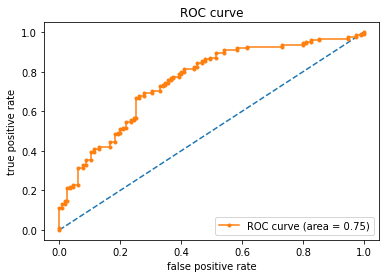

roc auc score: 0.6487406398910824


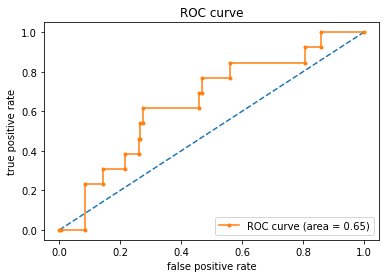

roc auc score: 0.6291866028708135


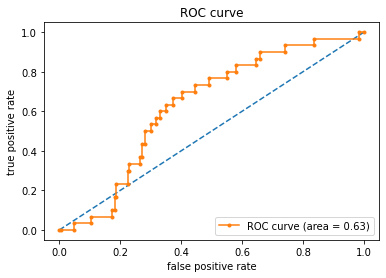

roc auc score: 0.738423645320197


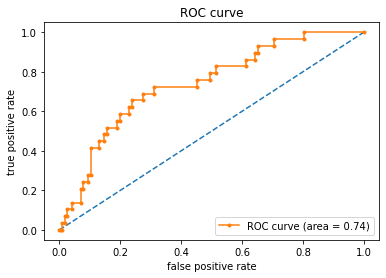

roc auc score: 0.5842924847664184


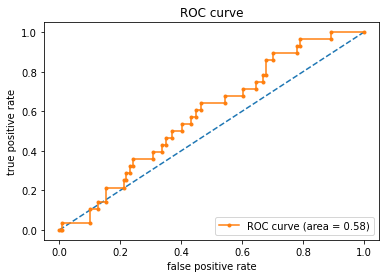

In [169]:
log_bsts = {}
for clmn in y_train.columns:
    param_grid = {
                'penalty' : ['l1', 'l2'],
                'class_weight' : ['balanced', None], 
                'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
                }

    grid_log = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced', max_iter=100, solver='newton-cg'), param_grid = param_grid , scoring = 'roc_auc')
    grid_log.fit(X_train, y_train[clmn])
    
    log_bsts[clmn] = grid_log.best_estimator_
    
    pred_proba = grid_log.best_estimator_.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val[clmn], pred_proba)
    print('roc auc score:', auc_score)
    plot_roc(y_val[clmn], pred_proba, auc_score)

### XGBoost

roc auc score: 0.7512973352033661


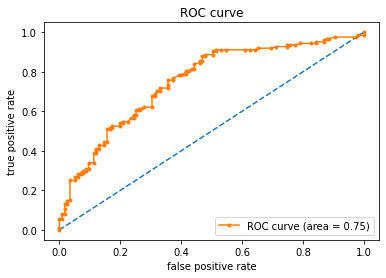

roc auc score: 0.5990469707283866


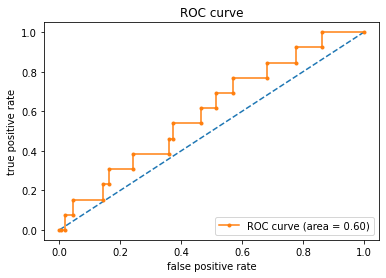

roc auc score: 0.6437001594896332


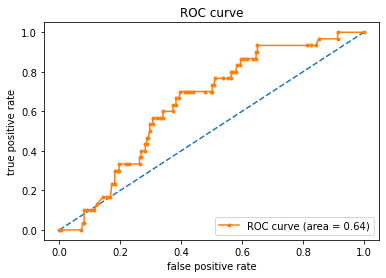

roc auc score: 0.7543513957307061


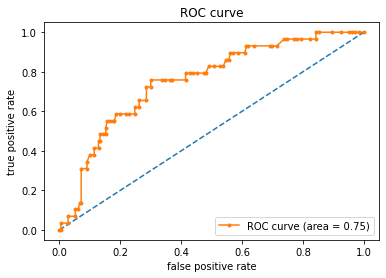

roc auc score: 0.5859851049424509


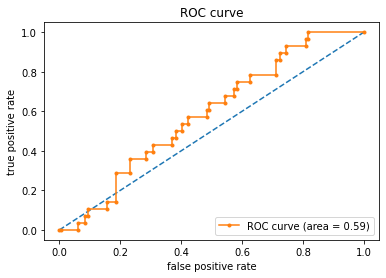

In [194]:
xgb_bsts = {}
for clmn in y_train.columns:
    param_grid = {
            'max_depth' : range(1, 3), 
            'n_estimators': [50, 100, 200]
            }

    grid_xgb = GridSearchCV(estimator = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_grid = param_grid , scoring = 'roc_auc')
    grid_xgb.fit(X_train, y_train[clmn])
    
    xgb_bsts[clmn] = grid_xgb.best_estimator_
    
    pred_proba = grid_xgb.best_estimator_.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val[clmn], pred_proba)
    print('roc auc score:', auc_score)
    plot_roc(y_val[clmn], pred_proba, auc_score)

### Decision tree

roc auc score: 0.7244039270687238


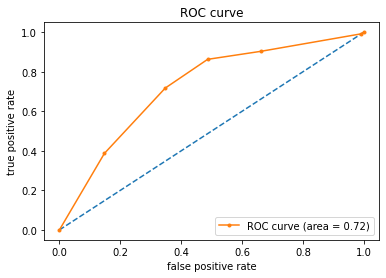

roc auc score: 0.7241320626276379


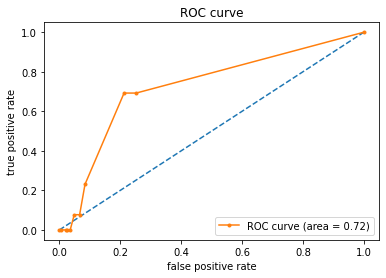

roc auc score: 0.6224082934609251


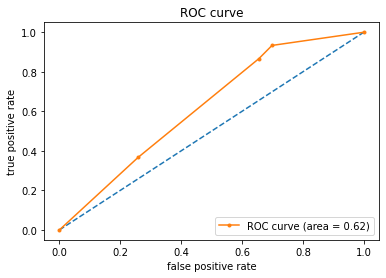

roc auc score: 0.6846469622331692


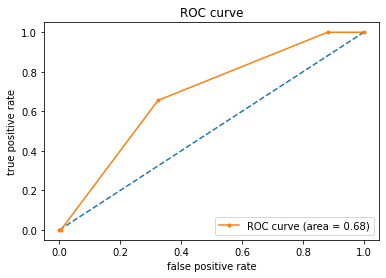

roc auc score: 0.5431618144888287


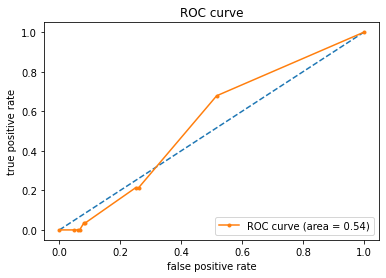

In [170]:
dt_bsts = {}
for clmn in y_train.columns:
    param_grid = {
                'max_depth': range(1, 12), 
                'min_samples_split': range(2, 10)
                }

    grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid , scoring = 'roc_auc')
    grid_dt.fit(X_train, y_train[clmn])
    
    dt_bsts[clmn] = grid_dt.best_estimator_

    pred_proba = grid_dt.best_estimator_.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val[clmn], pred_proba)
    print('roc auc score:', auc_score)
    plot_roc(y_val[clmn], pred_proba, auc_score)

### CatBoost

In [171]:
cat_bsts = {}
for clmn in y_train.columns:
    model = CatBoostClassifier(cat_features=['44', '45', '46', '47', '48', '49'])

    grid = {
            'one_hot_max_size':[2, 5, 10]
            }

    grid_search_result = model.grid_search(grid, 
                                           X=X_train, 
                                           y=y_train[clmn], 
                                           plot=True)
    
    cat_bsts[clmn] = grid_search_result['params']['one_hot_max_size']
    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838236	test: 0.6829881	best: 0.6829881 (0)	total: 97.7ms	remaining: 1m 37s
1:	learn: 0.6757881	test: 0.6748681	best: 0.6748681 (1)	total: 123ms	remaining: 1m 1s
2:	learn: 0.6678263	test: 0.6652570	best: 0.6652570 (2)	total: 139ms	remaining: 46.1s
3:	learn: 0.6612206	test: 0.6578628	best: 0.6578628 (3)	total: 148ms	remaining: 36.8s
4:	learn: 0.6542481	test: 0.6510235	best: 0.6510235 (4)	total: 180ms	remaining: 35.9s
5:	learn: 0.6448416	test: 0.6442432	best: 0.6442432 (5)	total: 203ms	remaining: 33.7s
6:	learn: 0.6373029	test: 0.6373533	best: 0.6373533 (6)	total: 224ms	remaining: 31.7s
7:	learn: 0.6315075	test: 0.6312244	best: 0.6312244 (7)	total: 237ms	remaining: 29.4s
8:	learn: 0.6252373	test: 0.6240974	best: 0.6240974 (8)	total: 259ms	remaining: 28.5s
9:	learn: 0.6189098	test: 0.6186775	best: 0.6186775 (9)	total: 281ms	remaining: 27.8s
10:	learn: 0.6134129	test: 0.6136343	best: 0.6136343 (10)	total: 317ms	remaining: 28.5s
11:	learn: 0.6067926	test: 0.6080631	best: 0.60806

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6519820	test: 0.6498648	best: 0.6498648 (0)	total: 2.4ms	remaining: 2.4s
1:	learn: 0.6140316	test: 0.6099173	best: 0.6099173 (1)	total: 16.6ms	remaining: 8.3s
2:	learn: 0.5791499	test: 0.5727923	best: 0.5727923 (2)	total: 32.3ms	remaining: 10.7s
3:	learn: 0.5463336	test: 0.5388421	best: 0.5388421 (3)	total: 46ms	remaining: 11.5s
4:	learn: 0.5163980	test: 0.5068100	best: 0.5068100 (4)	total: 53.7ms	remaining: 10.7s
5:	learn: 0.4895593	test: 0.4782865	best: 0.4782865 (5)	total: 60.2ms	remaining: 9.98s
6:	learn: 0.4649659	test: 0.4520030	best: 0.4520030 (6)	total: 68.7ms	remaining: 9.74s
7:	learn: 0.4417667	test: 0.4271054	best: 0.4271054 (7)	total: 83.8ms	remaining: 10.4s
8:	learn: 0.4209965	test: 0.4046716	best: 0.4046716 (8)	total: 89ms	remaining: 9.8s
9:	learn: 0.4019452	test: 0.3840068	best: 0.3840068 (9)	total: 93.4ms	remaining: 9.24s
10:	learn: 0.3843762	test: 0.3649912	best: 0.3649912 (10)	total: 103ms	remaining: 9.23s
11:	learn: 0.3684567	test: 0.3475922	best: 0.34759

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6715438	test: 0.6707810	best: 0.6707810 (0)	total: 4.33ms	remaining: 4.33s
1:	learn: 0.6514149	test: 0.6499358	best: 0.6499358 (1)	total: 13.3ms	remaining: 6.64s
2:	learn: 0.6239500	test: 0.6216849	best: 0.6216849 (2)	total: 43ms	remaining: 14.3s
3:	learn: 0.6029761	test: 0.5995257	best: 0.5995257 (3)	total: 68.2ms	remaining: 17s
4:	learn: 0.5835743	test: 0.5789706	best: 0.5789706 (4)	total: 108ms	remaining: 21.4s
5:	learn: 0.5675471	test: 0.5630172	best: 0.5630172 (5)	total: 135ms	remaining: 22.4s
6:	learn: 0.5539566	test: 0.5488469	best: 0.5488469 (6)	total: 142ms	remaining: 20.1s
7:	learn: 0.5406327	test: 0.5357011	best: 0.5357011 (7)	total: 163ms	remaining: 20.3s
8:	learn: 0.5258787	test: 0.5192239	best: 0.5192239 (8)	total: 191ms	remaining: 21s
9:	learn: 0.5145231	test: 0.5083063	best: 0.5083063 (9)	total: 204ms	remaining: 20.2s
10:	learn: 0.5008531	test: 0.4936652	best: 0.4936652 (10)	total: 235ms	remaining: 21.1s
11:	learn: 0.4908176	test: 0.4842675	best: 0.4842675 (

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6662108	test: 0.6659308	best: 0.6659308 (0)	total: 1.29ms	remaining: 1.28s
1:	learn: 0.6403684	test: 0.6400758	best: 0.6400758 (1)	total: 13ms	remaining: 6.46s
2:	learn: 0.6163658	test: 0.6162073	best: 0.6162073 (2)	total: 28.3ms	remaining: 9.41s
3:	learn: 0.5943087	test: 0.5943399	best: 0.5943399 (3)	total: 41.5ms	remaining: 10.3s
4:	learn: 0.5744132	test: 0.5741666	best: 0.5741666 (4)	total: 49.9ms	remaining: 9.92s
5:	learn: 0.5558688	test: 0.5553335	best: 0.5553335 (5)	total: 58.9ms	remaining: 9.76s
6:	learn: 0.5373680	test: 0.5370013	best: 0.5370013 (6)	total: 72.5ms	remaining: 10.3s
7:	learn: 0.5213917	test: 0.5205854	best: 0.5205854 (7)	total: 81.8ms	remaining: 10.1s
8:	learn: 0.5058871	test: 0.5050067	best: 0.5050067 (8)	total: 98.7ms	remaining: 10.9s
9:	learn: 0.4922631	test: 0.4911253	best: 0.4911253 (9)	total: 111ms	remaining: 11s
10:	learn: 0.4795996	test: 0.4782287	best: 0.4782287 (10)	total: 117ms	remaining: 10.5s
11:	learn: 0.4663837	test: 0.4646154	best: 0.46

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6643476	test: 0.6627022	best: 0.6627022 (0)	total: 4.67ms	remaining: 4.67s
1:	learn: 0.6368282	test: 0.6335602	best: 0.6335602 (1)	total: 23.7ms	remaining: 11.8s
2:	learn: 0.6117608	test: 0.6079135	best: 0.6079135 (2)	total: 56.7ms	remaining: 18.9s
3:	learn: 0.5886435	test: 0.5835532	best: 0.5835532 (3)	total: 66.1ms	remaining: 16.5s
4:	learn: 0.5667157	test: 0.5599818	best: 0.5599818 (4)	total: 75.9ms	remaining: 15.1s
5:	learn: 0.5462611	test: 0.5387236	best: 0.5387236 (5)	total: 108ms	remaining: 17.9s
6:	learn: 0.5276651	test: 0.5186454	best: 0.5186454 (6)	total: 118ms	remaining: 16.8s
7:	learn: 0.5108118	test: 0.5005206	best: 0.5005206 (7)	total: 130ms	remaining: 16.1s
8:	learn: 0.4949878	test: 0.4838228	best: 0.4838228 (8)	total: 141ms	remaining: 15.5s
9:	learn: 0.4803116	test: 0.4677895	best: 0.4677895 (9)	total: 152ms	remaining: 15s
10:	learn: 0.4669666	test: 0.4531108	best: 0.4531108 (10)	total: 179ms	remaining: 16.1s
11:	learn: 0.4545107	test: 0.4394493	best: 0.4394

### Оценка качества выбранной метрикой

In [179]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import statistics

In [195]:
# xgboost
xgb_f1 = []
for clmn in y_train.columns:
    xgb_f1.append(f1_score(xgb_bsts[clmn].predict(X_val), y_val[clmn]))
    print(clmn, ':', xgb_bsts[clmn].predict(X_val))
    print('А ориг такой:', y_val[clmn])

Артериальная гипертензия : [1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0
 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1
 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1
 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0]
А ориг такой: 241    1
846    0
415    1
385    1
563    1
      ..
842    0
16     0
541    1
579    1
871    0
Name: Артериальная гипертензия, Length: 239, dtype: int8
ОНМК : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0

In [201]:
print('Результирующие значение на XGBoost =', xgb_f1)

Результирующие значение на XGBoost = [0.691358024691358, 0.0, 0.0, 0.0, 0.0]


In [204]:
# catboost
cat_f1 = []
cat_models = {}
for clmn in y_train.columns:
    cb = CatBoostClassifier(cat_features=['44', '45', '46', '47', '48', '49'], one_hot_max_size=cat_bsts[clmn], silent=True)
    cb.fit(X_train, y_train[clmn])
    cat_models[clmn] = cb
    cat_f1.append(f1_score(cb.predict(X_val), y_val[clmn]))
    print(clmn, ':', cb.predict(X_val))
    

Артериальная гипертензия : [1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0
 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0
 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1
 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1
 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0]
ОНМК : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [205]:
print('Результирующие значение на CatBoost =', cat_f1)
print('Среднее значение:', statistics.mean(cat_f1))

Результирующие значение на CatBoost = [0.6637931034482759, 0.0, 0.0, 0.0, 0.0]
Среднее значение: 0.1327586206896552


### Предсказание (инференс) модели на новых данных:

In [206]:
train = pd.read_pickle(os.path.join(processed_data_path, 'train.pkl'))
test = pd.read_pickle(os.path.join(processed_data_path, 'test.pkl'))

In [207]:
train = pd.DataFrame(ppl.fit_transform(train))
test = pd.DataFrame(ppl.fit_transform(test))

In [208]:
for complic_clmns in ['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Профессия']:
    for not_inter in set(train[complic_clmns]) ^ set(test[complic_clmns]):
        if not_inter not in test[complic_clmns].unique():
            test = test.append(train[train[complic_clmns] == not_inter].iloc[0])
        else:
            test[complic_clmns] = test[complic_clmns].replace(not_inter, train[complic_clmns].mode()[0])

In [209]:
test_len = test.shape[0]
test = pd.DataFrame(encoder_pipeline.fit_transform(test)).iloc[:test_len]

In [210]:
test.columns = test.columns.astype(str)
for clmn in ['44', '45', '46', '47', '48', '49']:
    test[clmn] = test[clmn].apply(lambda el: round(el * 100))

In [211]:
# xgboost
print('Полученные значения (xgboost):')
for clmn in y_train.columns:
    print(clmn, ':', xgb_bsts[clmn].predict(test))

Полученные значения (xgboost):
Артериальная гипертензия : [1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1
 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1
 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0
 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1
 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0
 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1
 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0

In [212]:
# catboost
print('Полученные значения (catboost):')
for clmn in y_train.columns:
    print(clmn, ':', cat_models[clmn].predict(test))

Полученные значения (catboost):
Артериальная гипертензия : [1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1
 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1
 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0
 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0
 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 

## Вывод

Из полученных результатов можно сделать, что у нас не вышло правильно классифицировать все лейблы, а лишь только первый, ввиду сильной несбалансированности данных.